In [1]:
# Import all necessary packages
import os
from os import sep
import pubchempy as pcp
import pandas as pd
from collections import defaultdict
import numpy as np
from numpy import nan
from IPython.display import Image
import tabula
from tabula import read_pdf
from tabulate import tabulate
from tabula import read_pdf_with_template
import pdfplumber

## Import Data From CSV

In [2]:
# Read in list of chemicals data file and change the name of column.
dataset = pd.read_csv ("../Data/List_of_Chemicals.csv")
dataset.rename(columns = {'Chemical name' : 'Chemical_Name'}, inplace = True)

In [4]:
# View datafile.
dataset;

In [5]:
# Extract column ad new dataset for analysis.
ChemList_Column = dataset["Chemical_Name"]

In [6]:
# View new dataset
type(ChemList_Column)

pandas.core.series.Series

## PubChem

In [7]:
# Use PubChempy to obtain chemical identifiers and insert into cidlist created for exact number of chemicals.
cidlist = [] # list of cids
unfoundcid = [] # list of unfound chemicals
foundcid = []  # list of found chemicals
for i,d in enumerate(ChemList_Column):
    values = pcp.get_cids(d)
    if len(values) > 0:
        cidlist.append(values[0])
        foundcid.append(d)
    else:
        unfoundcid.append(d)

In [8]:
# cidlist and foundcid size
(len(cidlist),len(foundcid), len(unfoundcid))

(157, 157, 52)

In [9]:
# List of unfound chemical names
unfoundcid;

In [10]:
# List of all found chemical names
foundcid;

In [12]:
# List of all found CIDs
cidlist;

In [13]:
# Use identifiers to obtain properties of the chemicals (MolecularFormula, MW, and SMILES) in place in correct list
# Runs in 4 minutes
count = len(cidlist)
Formula, Weight, Smiles = [None] * count,[None] * count,[None] * count

for i,d in enumerate(cidlist):
    if d != None:
        Formula[i] = pcp.get_properties(['MolecularFormula'],d)[0]['MolecularFormula']
        Weight[i] = float(pcp.get_properties(['MolecularWeight'], d)[0]['MolecularWeight'])
        Smiles[i] = pcp.get_properties(['CanonicalSMILES'],d)[0]['CanonicalSMILES']

In [14]:
print(f'Found Smiles: {sum(x is not None for x in Smiles)} of total:{len(Smiles)}')

Found Smiles: 157 of total:157


In [16]:
Smiles;

## SwissADME
---

These must be installed. 

FireFox Browser MUST be installed on your computer. 

Install selenium package (only once)
pip install selenium

install geckodriver (only once)
pip install geckodriver-autoinstaller


In [17]:
import geckodriver_autoinstaller
geckodriver_autoinstaller.install();

from selenium import webdriver
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import csv
import requests


In [23]:
# SwissADME code
# THIS SECTION TAKES ~20 MIN

# Create list for SwissADME links
SwissAdme_links = [None] * len(Smiles)

# Name each elements for code
name = "smiles"
button = "submitButton"
path = '//*[@id="sib_body"]/div[7]/a[1]'
website = "http://www.swissadme.ch"

# Loop through all the Smiles and get the list of links
for i,d in enumerate(Smiles):
    # This will run headless - runs in the background
    options = Options()
    options.headless = True
    driver = Firefox(options=options)
    wait = WebDriverWait(driver,40)
    # Open SwissADME database
    driver.get(website)
    
    # Locate search box on SwissADME and import the smiles from previously created list
    element1 = wait.until(EC.presence_of_element_located((By.NAME, name)))
    smiles_search_ADME = driver.find_element(By.NAME,name).send_keys(d) 
    
    # Find and click Submit
    element2 = wait.until(EC.presence_of_element_located((By.ID, button)))
    run = driver.find_element(By.ID,button).submit()
    
    # Locate href link (csv link)
    element3 = wait.until(EC.visibility_of_element_located((By.ID,"mol-cell-1")))
    csvlinks_ADME = driver.find_element(By.XPATH, path).get_property('href')
    
    SwissAdme_links[i] = csvlinks_ADME

    # Close browser
    driver.close()     

In [24]:
print(f'Links: {sum(x is not None for x in SwissAdme_links)} of total:{len(SwissAdme_links)}')

Links: 157 of total:157


In [25]:
SwissAdme_data = [None] * len(SwissAdme_links)
for i,d in enumerate(SwissAdme_links):
     SwissAdme_data[i] =  pd.read_csv(d, sep=",")

In [27]:
SwissAdme_data;

In [28]:
print(f' Returned data from {sum(x is not None for x in SwissAdme_data)} of total {len(SwissAdme_data)} Requested')

 Returned data from 157 of total 157 Requested


In [29]:
unfoundchemicals = []
for i,d in enumerate(SwissAdme_data):
    if d.empty:
        print(foundcid[i], "-", Smiles[i])

In [30]:
# Concatonate all the csv files into one
result = pd.concat(SwissAdme_data)

In [34]:
# View result
result

,Chemical_Name,Canonical SMILES,Formula,MW,#Heavy atoms,#Aromatic heavy atoms,Fraction Csp3,#Rotatable bonds,#H-bond acceptors,#H-bond donors,...,Lipinski #violations,Ghose #violations,Veber #violations,Egan #violations,Muegge #violations,Bioavailability Score,PAINS #alerts,Brenk #alerts,Leadlikeness #violations,Synthetic Accessibility
0,Prunasin,OCC1OC(OC(c2ccccc2)C#N)C(C(C1O)O)O,C14H17NO6,295.29,21,6,0.50,4,7,4,...,0,1,0,0,0,0.55,0,0,0,4.21
0,amygdalin,OCC1OC(OCC2OC(OC(c3ccccc3)C#N)C(C(C2O)O)O)C(C(...,C20H27NO11,457.43,32,6,0.65,7,12,7,...,2,1,1,1,4,0.17,0,0,1,5.41
0,Emodin,Cc1cc(O)c2c(c1)C(=O)c1c(C2=O)c(O)cc(c1)O,C15H10O5,270.24,20,12,0.07,0,5,3,...,0,0,0,0,0,0.55,1,0,0,2.57
0,Hordenine,CN(CCc1ccc(cc1)O)C,C10H15NO,165.23,12,6,0.40,3,2,1,...,0,0,0,0,1,0.55,0,0,1,1.00
0,N-methyl-4-methoxyphenethylamine,CNCCc1ccc(cc1)OC,C10H15NO,165.23,12,6,0.40,4,2,1,...,0,0,0,0,1,0.55,0,0,1,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Quercetagetin,Oc1ccc(cc1O)c1oc2cc(O)c(c(c2c(=O)c1O)O)O,C15H10O8,318.24,23,16,0.00,1,8,6,...,1,0,1,1,2,0.55,1,1,0,3.27
0,Quercetin,Oc1cc(O)c2c(c1)oc(c(c2=O)O)c1ccc(c(c1)O)O,C15H10O7,302.24,22,16,0.00,1,7,5,...,0,0,0,0,0,0.55,1,1,0,3.23
0,Scoparone,COc1cc2oc(=O)ccc2cc1OC,C11H10O4,206.19,15,10,0.18,2,4,0,...,0,0,0,0,0,0.55,0,1,1,2.77
0,Skimmin,OCC1OC(Oc2ccc3c(c2)oc(=O)cc3)C(C(C1O)O)O,C15H16O8,324.28,23,10,0.40,3,8,4,...,0,1,0,0,0,0.55,0,1,0,4.68


In [32]:
# Insert Chemical Names to results
result.insert(0, 'Chemical_Name', foundcid)

In [33]:
# Drop useless column
result.drop(['Molecule'], axis=1,inplace=True)

In [70]:
# Export ADME
#  as csv. 
result.to_csv('../Output/FOUND_ADME_data_Induced_Avoided.csv', index=False)

In [ ]:
# Export Chemical names of chemicals with no CIDs as CSV
Unfound_Chemicals = pd.DataFrame(unfoundcid, columns=["Chemical_Name"])
Unfound_Chemicals.to_csv('../Output/UNFOUND_Chemicals.csv', index=False)

## Visualize Chemical Space

In [35]:
import rdkit
from rdkit import Chem

RDKit WARNING: [13:19:26] Enabling RDKit 2019.09.3 jupyter extensions
[13:19:26] Enabling RDKit 2019.09.3 jupyter extensions


In [36]:
from chemplot import Plotter, load_data
import matplotlib.pyplot as plt

sim_type indicates the similarity type by which the plots are constructed.
The supported similarity types are structural and tailored.
Because no target list has been provided 'structural' as been selected as sym_type.


<AxesSubplot:label='scatter', title={'center':'UMAP plot'}, xlabel='UMAP-1', ylabel='UMAP-2'>

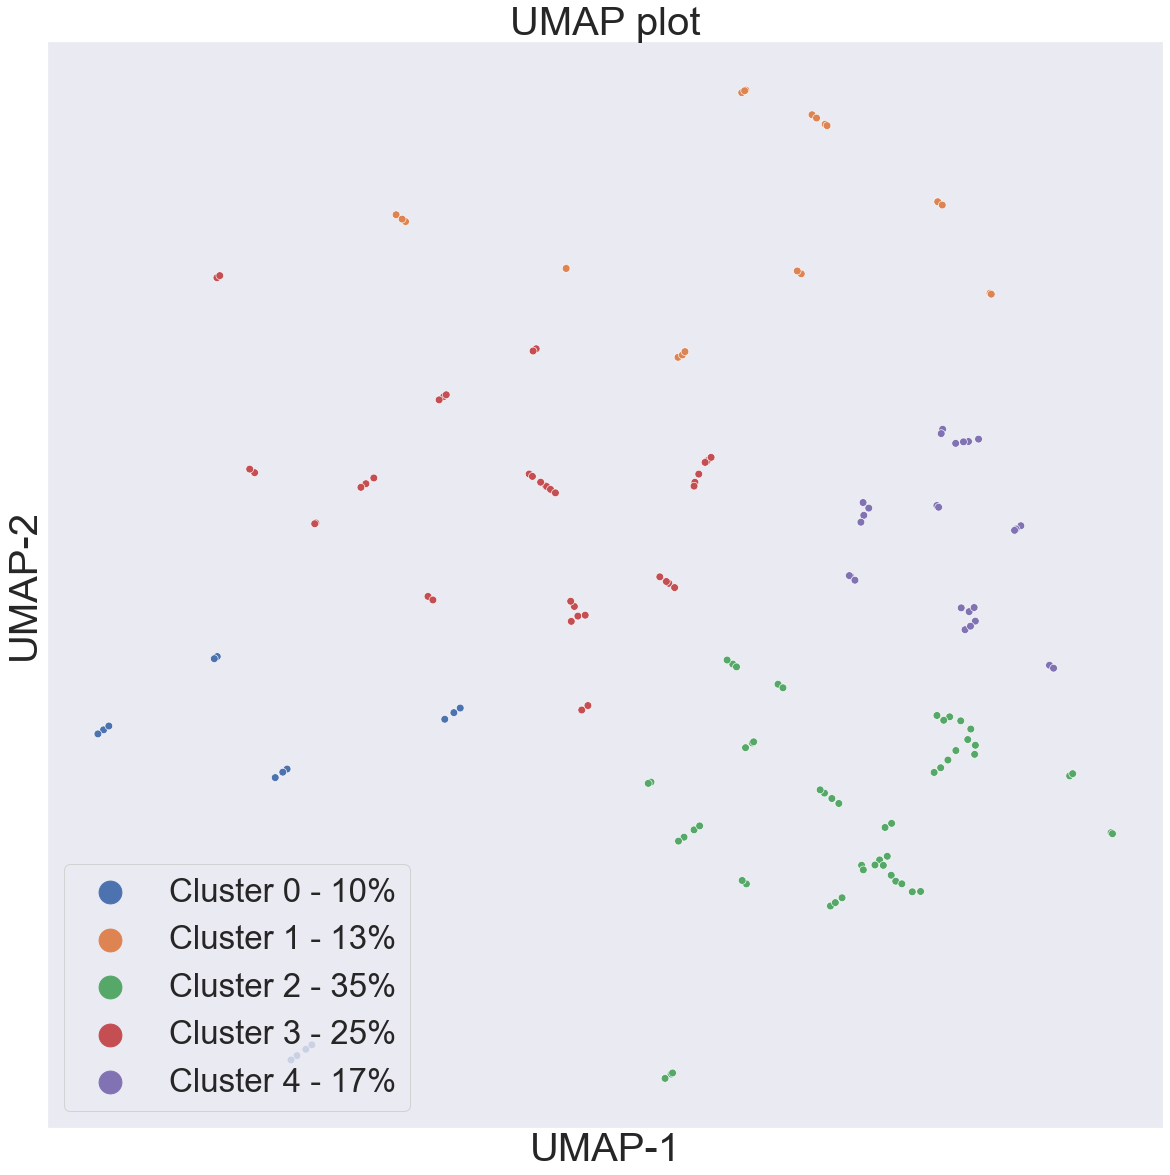

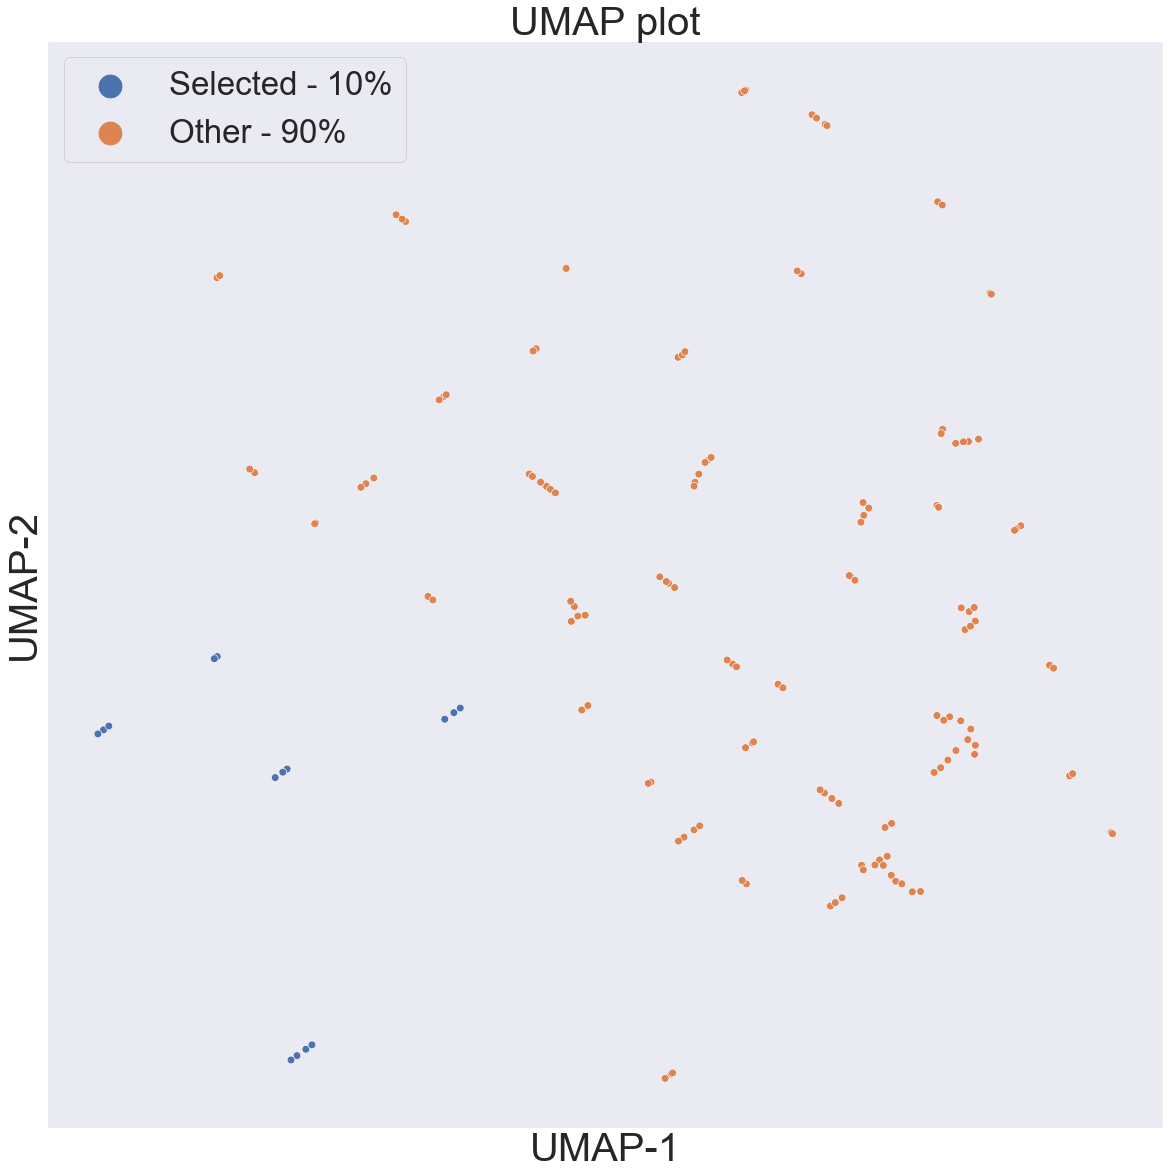

In [37]:
# Use Smiles list from pubchem
cp = Plotter.from_smiles(Smiles, target_type="R")
# Reduce dimensions of molecular discriptors
cp.umap(random_state=500)
# Identify clusteers in data
cp.cluster()
# Visualize the plot
cp.visualize_plot(clusters=True)
# Selecting a spacific cluster ex: 0, 1, ect
cp.visualize_plot(clusters=0)

<AxesSubplot:label='scatter', title={'center':'t-SNE plot'}, xlabel='t-SNE-1', ylabel='t-SNE-2'>

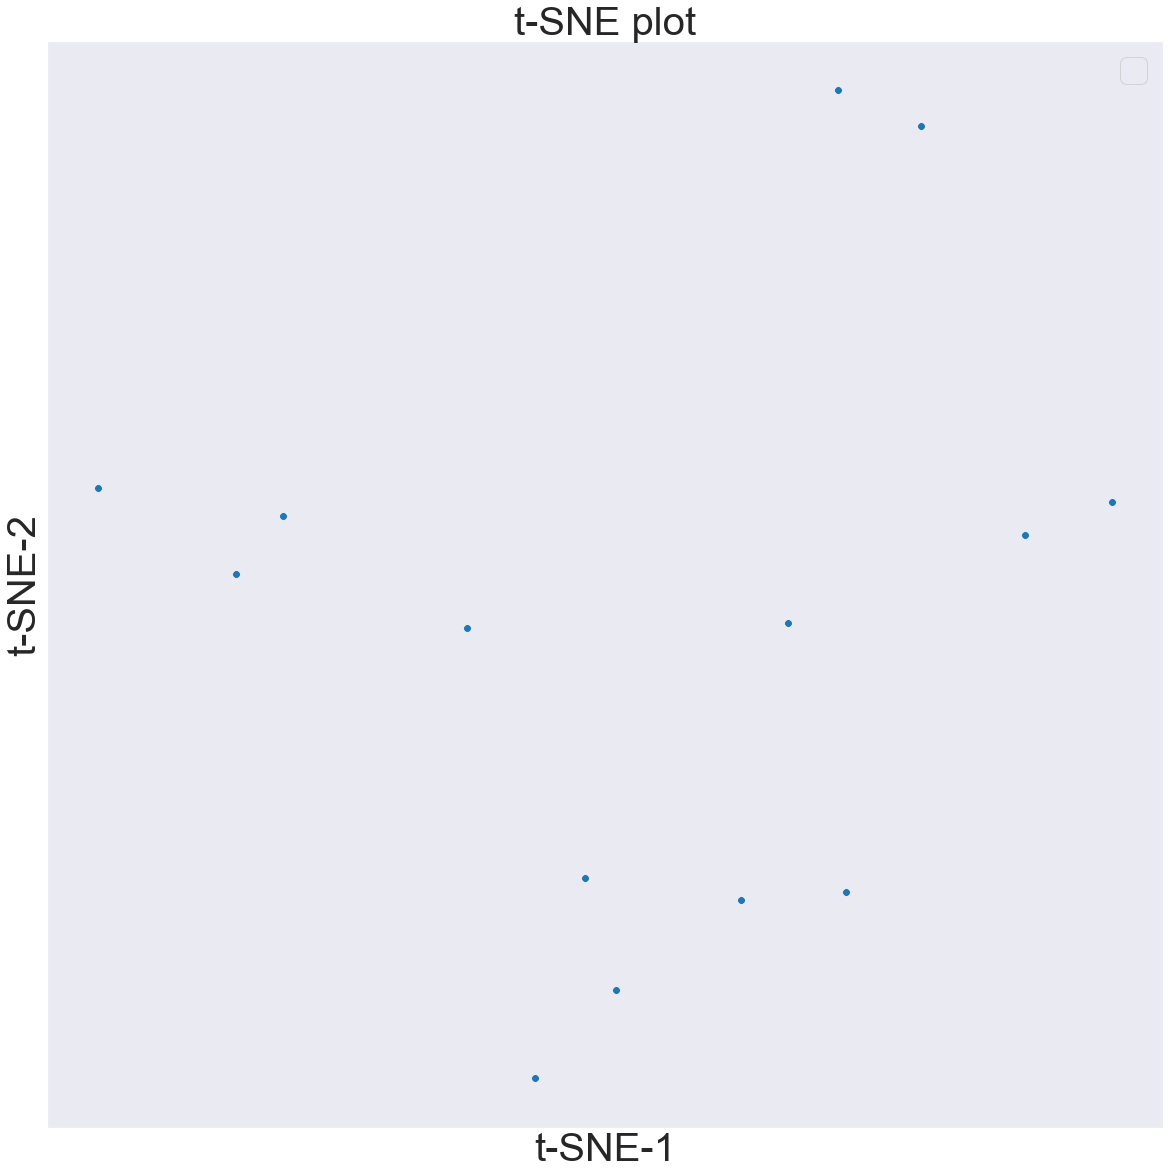

In [75]:
cp.tsne() 
cp.visualize_plot()

In [38]:
cp.interactive_plot(show_plot=True)

Figure(id='1002', ...)

## SwissTargetPrediction

In [ ]:
# Install html table parser
# pip install html-table-parser-python3

In [ ]:
from lxml import etree
import urllib.request

In [ ]:
# SwissADME code
# THIS SECTION TAKES ~20 MIN

# Create list for SwissADME links
SwissTP_links = [None] * len(Smiles)
temp = [None]
# Name each elements for code
name = "smiles"
button = "submitButton"
table = "resultTable"
path = '//*[@id="sib_body"]/div[7]/a[1]'
website = "http://www.swisstargetprediction.ch"

# Loop through all the Smiles and get the list of links
for i,d in enumerate(Smiles):
    # This will run headless - runs in the background
    driver = Firefox()
    wait = WebDriverWait(driver,30)
    # Open SwissADME database
    driver.get(website)
    
    # Locate search box on SwissADME and import the smiles from previously created list
    element1 = wait.until(EC.visibility_of_element_located((By.NAME, name)))
    smiles_search_TP = driver.find_element(By.NAME,name).send_keys(d) 
    
    # Find and click Submit
    element2 = wait.until(EC.visibility_of_element_located((By.ID, button)))
    run = driver.find_element(By.ID,button).submit()
    
    # Locate href link (csv link)
    element3 = wait.until(EC.visibility_of_element_located((By.ID,"resultTable")))
    TPtable = driver.find_element(By.ID, table).text
    temp.append(TPtable)
    tempdf = pd.DataFrame(temp)

    # Close browser
    driver.close()  

UnexpectedAlertPresentException: Alert Text: None
Message: Dismissed user prompt dialog: No similar actives found. No target predicted.


In [ ]:
temp

[None,
 'Target Common name Uniprot ID ChEMBL ID Target Class Probability* Known actives (3D/2D)\nSodium/glucose cotransporter 2 SLC5A2 P31639 CHEMBL3884 Electrochemical transporter 0.0978745343258\n243 / 119     \nVascular endothelial growth factor A VEGFA P15692 CHEMBL1783 Secreted protein 0.0978745343258\n0 / 2     \nAcidic fibroblast growth factor FGF1 P05230 CHEMBL2120 Secreted protein 0.0978745343258\n0 / 2     \nBasic fibroblast growth factor FGF2 P09038 CHEMBL3107 Secreted protein 0.0978745343258\n0 / 2     \nHeparanase HPSE Q9Y251 CHEMBL3921 Enzyme 0.0978745343258\n0 / 2     \nDipeptidyl peptidase IV DPP4 P27487 CHEMBL284 Protease 0.0978745343258\n3 / 0     \nAdenosine kinase ADK P55263 CHEMBL3589 Enzyme 0.0978745343258\n72 / 0     \nAdenosine deaminase ADA P00813 CHEMBL1910 Hydrolase 0.0978745343258\n11 / 0     \nMAP kinase ERK2 MAPK1 P28482 CHEMBL4040 Kinase 0.0978745343258\n2 / 0     \nAdenosine A2a receptor ADORA2A P29274 CHEMBL251 Family A G protein-coupled receptor 0.097

In [ ]:
tempdf

,0
0,None
1,Target Common name Uniprot ID ChEMBL ID Target...
2,Target Common name Uniprot ID ChEMBL ID Target...
3,Target Common name Uniprot ID ChEMBL ID Target...
4,Target Common name Uniprot ID ChEMBL ID Target...
...,...
75,Target Common name Uniprot ID ChEMBL ID Target...
76,Target Common name Uniprot ID ChEMBL ID Target...
77,Target Common name Uniprot ID ChEMBL ID Target...
78,Target Common name Uniprot ID ChEMBL ID Target...


In [ ]:
TPtable

'Target Common name Uniprot ID ChEMBL ID Target Class Probability* Known actives (3D/2D)\n11-beta-hydroxysteroid dehydrogenase 1 HSD11B1 P28845 CHEMBL4235 Enzyme 0.117056357516\n131 / 21     \nHMG-CoA reductase (by homology) HMGCR P04035 CHEMBL402 Oxidoreductase 0.0898720672475\n32 / 88     \nProtein kinase C alpha PRKCA P17252 CHEMBL299 Kinase 0.0898720672475\n11 / 74     \nVitamin D receptor VDR P11473 CHEMBL1977 Nuclear receptor 0.071715932485\n1 / 3     \nMu opioid receptor OPRM1 P35372 CHEMBL233 Family A G protein-coupled receptor 0.0626219668353\n25 / 4     \nKappa Opioid receptor OPRK1 P41145 CHEMBL237 Family A G protein-coupled receptor 0.0626219668353\n52 / 19     \nSerine/threonine-protein phosphatase PPP5C Q9BPW0 CHEMBL1293265 Phosphatase 0.0626219668353\n0 / 3     \nSerine/threonine protein phosphatase PP1-alpha catalytic subunit PPP1CA P62136 CHEMBL2164 Phosphatase 0.0626219668353\n0 / 3     \nProtein phosphatase 2C beta PPM1B O75688 CHEMBL2845 Phosphatase 0.0626219668353\